In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
def preprocess_design_matrix(design_matrix):


    design_matrix = design_matrix[
        design_matrix['verified_infection'] == 1
    ].copy()
    
    design_matrix = design_matrix[
        ((
            #(design_matrix['e_coli_urine_culture'] != 1) |
            (design_matrix['urinary_tract_infection'] != 1) |
            (design_matrix['abdominal_infection'] != 1) |
            (design_matrix['pseud_blood_culture'] != 1) |
            (design_matrix['k_pneu_blood_culture'] != 1) |
            (design_matrix['h_influ_blood_culture'] != 1) |
            (design_matrix['mnc_blood_culture'] != 1) |
            (design_matrix['k_pneu_blood_culture'] != 1) |
            (design_matrix['enterobact_blood_culture'] != 1) |
            (design_matrix['other_g_neg_blood_culture'] != 1) |
            (design_matrix['k_pneu_blood_culture'] != 1)
        ) & (design_matrix['e_coli_blood_culture'] == 0)) |
        (design_matrix['e_coli_blood_culture'] == 1)
    ].copy()

    design_matrix['group'] = np.where(
        design_matrix['e_coli_blood_culture'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     



# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='e_coli_blood_culture', ylabel='Count'>

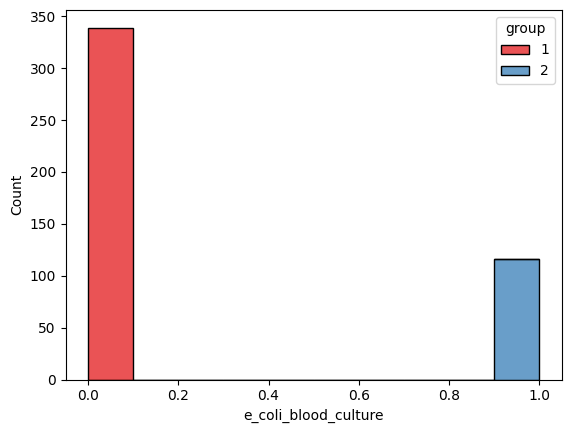

In [7]:
sns.histplot(
    design_matrix_train,
    x="e_coli_blood_culture",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [8]:
design_matrix_train['group'].value_counts()

group
1    339
2    116
Name: count, dtype: int64

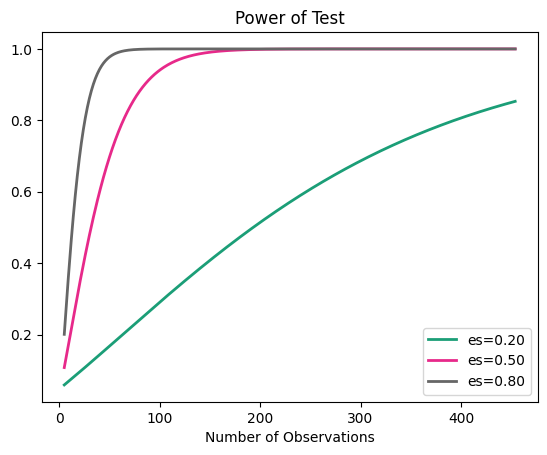

In [9]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [10]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [11]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_train.write("de_results/ecoli_de_proteins.tsv")

In [13]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

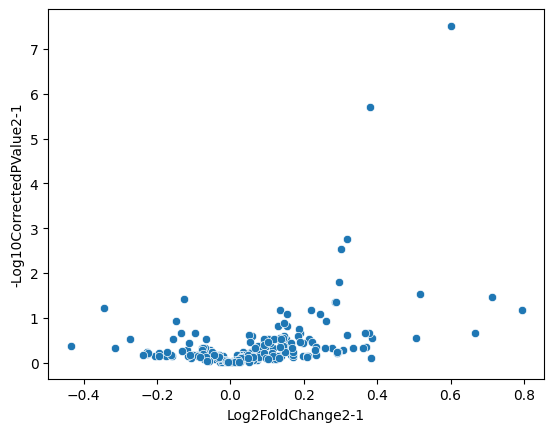

In [14]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [15]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [16]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [17]:
protein_columns = training_data.columns.to_list()

In [18]:
len(protein_columns)

287

In [19]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [21]:
y['label'].value_counts()

label
0    339
1    116
Name: count, dtype: int64

In [22]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.6710914454277286, 1: 1.9612068965517242}

In [23]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [24]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


In [25]:
selected_proteins

['C163A_HUMAN',
 'FCN3_HUMAN',
 'PGRP2_HUMAN',
 'FCG3A_HUMAN',
 'PZP_HUMAN',
 'A2AP_HUMAN',
 'APOA4_HUMAN',
 'VWF_HUMAN',
 'CAMP_HUMAN',
 'ALDOB_HUMAN',
 'H4_HUMAN',
 'CATB_HUMAN',
 'CATD_HUMAN',
 'CETP_HUMAN',
 'FGL1_HUMAN',
 'IBP7_HUMAN',
 'CO6A1_HUMAN',
 'ENOA_HUMAN',
 'SHBG_HUMAN',
 'MASP2_HUMAN',
 'TRY1_HUMAN',
 'A2MG_HUMAN',
 'HRG_HUMAN',
 'ALBU_HUMAN',
 'AMPN_HUMAN',
 'G3P_HUMAN',
 'SODE_HUMAN',
 'CALM1_HUMAN',
 'GPX3_HUMAN',
 'ICAM2_HUMAN',
 'HGFA_HUMAN',
 'ZPI_HUMAN',
 'VCAM1_HUMAN',
 'GELS_HUMAN',
 'FCN2_HUMAN',
 'ZA2G_HUMAN',
 'IL1AP_HUMAN',
 'LAMP2_HUMAN',
 'TRFE_HUMAN',
 'CFAD_HUMAN',
 'CPN2_HUMAN',
 'LKHA4_HUMAN',
 'VSIG4_HUMAN',
 'ICAM1_HUMAN',
 'COMP_HUMAN',
 'ITIH2_HUMAN',
 'BIP_HUMAN',
 'PI16_HUMAN',
 'NID1_HUMAN',
 'KAIN_HUMAN']

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [27]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6630679262258209, 0.471214320270924, 0.7252091321017776, 0.7046903052958013)

In [28]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [29]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [30]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [31]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,C163A_HUMAN,0.911311,2.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.609166,...,1.000000,1.0,1.000000,1.0,0.836128,0.938637,0.200781,3.96,2.0,4.694549
32,VCAM1_HUMAN,1.000000,1.0,0.655901,5.0,0.540567,13.0,0.290717,26.0,0.679210,...,0.496015,7.0,0.808508,2.0,0.697583,0.697934,0.244821,6.78,4.0,7.904199
27,CALM1_HUMAN,0.689555,3.0,0.618541,6.0,0.856159,3.0,0.279186,27.0,0.252638,...,0.474497,9.0,0.522508,6.0,0.545803,0.516070,0.227433,10.40,8.0,8.636310
6,APOA4_HUMAN,0.238137,26.0,0.662482,4.0,0.818544,5.0,0.321087,25.0,1.000000,...,0.520521,4.0,0.183829,29.0,0.490166,0.405359,0.275430,14.66,13.0,12.522481
10,H4_HUMAN,0.459755,9.0,0.531913,9.0,0.889425,2.0,0.111922,42.0,0.256559,...,0.597660,2.0,0.047613,45.0,0.482193,0.457827,0.241292,13.81,11.0,10.697583
49,KAIN_HUMAN,0.478072,7.0,0.494227,10.0,0.773784,8.0,0.229544,32.0,0.174117,...,0.167842,38.0,0.193003,27.0,0.425064,0.421893,0.262056,18.08,13.5,13.813096
33,GELS_HUMAN,0.307863,14.0,0.470543,12.0,0.238270,30.0,0.711085,3.0,0.268050,...,0.357967,17.0,0.536634,5.0,0.413820,0.384451,0.257017,17.97,14.0,14.206596
41,LKHA4_HUMAN,0.247600,23.0,0.245403,26.0,0.821959,4.0,0.574716,8.0,0.703512,...,0.395716,12.0,0.232398,23.0,0.396889,0.376458,0.244654,18.36,15.0,13.332212
45,ITIH2_HUMAN,0.287622,19.0,0.770369,2.0,0.148785,35.0,0.598725,7.0,0.108664,...,0.396560,11.0,0.407971,10.0,0.382448,0.342334,0.243291,19.55,17.0,13.950399
23,ALBU_HUMAN,0.372604,12.0,0.470693,11.0,0.292904,25.0,0.406879,14.0,0.320603,...,0.511587,5.0,0.028763,47.0,0.352234,0.292579,0.225277,20.96,20.5,13.959480


In [32]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [33]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [34]:
selected_features = selected_proteins[:10]

In [35]:
for feature in selected_features:

    print(feature)

C163A_HUMAN
VCAM1_HUMAN
CALM1_HUMAN
APOA4_HUMAN
H4_HUMAN
KAIN_HUMAN
GELS_HUMAN
LKHA4_HUMAN
ITIH2_HUMAN
ALBU_HUMAN


In [36]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [37]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6988304093567251,
 0.4611111111111111,
 0.7143604043220635,
 0.7092972105780676)

In [38]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.40463337831758883,
 0.3524220976192665,
 0.6592889508539561,
 0.5754730313416853)

In [39]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [40]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [41]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [42]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
0,C163A_HUMAN,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,...,1.000000,1.0,1.000000,1.0,0.996947,1.000000,0.016771,1.05,1.0,0.261116
4,H4_HUMAN,0.453415,3.0,0.619319,4.0,0.515856,3.0,0.418171,3.0,0.377009,...,0.546133,3.0,0.171419,5.0,0.480144,0.465821,0.195289,3.96,4.0,1.746107
9,ALBU_HUMAN,0.493634,2.0,0.692711,2.0,0.220577,6.0,0.330146,7.0,0.496372,...,0.608179,2.0,0.231586,3.0,0.413845,0.381256,0.203947,4.79,5.0,2.203280
7,LKHA4_HUMAN,0.202345,8.0,0.397288,7.0,0.564652,2.0,0.450090,2.0,0.419908,...,0.501439,4.0,0.130376,9.0,0.406169,0.397198,0.204705,5.15,5.0,2.491906
3,APOA4_HUMAN,0.252938,6.0,0.191408,9.0,0.495740,4.0,0.285877,8.0,0.652084,...,0.211281,8.0,0.171166,6.0,0.359505,0.324086,0.234124,6.03,6.0,2.657009
2,CALM1_HUMAN,0.355099,4.0,0.527102,5.0,0.396367,5.0,0.335953,6.0,0.320674,...,0.405768,5.0,0.219312,4.0,0.339545,0.330153,0.155240,5.96,6.0,2.382258
8,ITIH2_HUMAN,0.000802,10.0,0.639438,3.0,0.057483,10.0,0.336477,5.0,0.216182,...,0.351436,6.0,0.165946,8.0,0.309302,0.291390,0.182819,6.38,7.0,2.246344
5,KAIN_HUMAN,0.327900,5.0,0.442637,6.0,0.213899,8.0,0.363809,4.0,0.114693,...,0.126316,9.0,0.080993,10.0,0.303810,0.281312,0.197560,6.40,6.0,2.457723
6,GELS_HUMAN,0.131979,9.0,0.301068,8.0,0.087412,9.0,0.115321,10.0,0.189070,...,0.268448,7.0,0.166318,7.0,0.235811,0.203210,0.175248,7.62,8.0,2.277603
1,VCAM1_HUMAN,0.244715,7.0,0.065833,10.0,0.214068,7.0,0.119910,9.0,0.101980,...,0.118442,10.0,0.370808,2.0,0.197907,0.201110,0.135122,7.66,8.0,2.400421


In [43]:
final_protein_importances.to_csv(
    "feature_importances/ecoli_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [44]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [45]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [46]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [47]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [48]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [49]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [50]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [51]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [52]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [53]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.4666666666666667,
 0.34394904458598724,
 0.27751196172248804,
 0.348993288590604,
 0.2535211267605634,
 0.29213483146067415,
 0.39800995024875624,
 0.3728813559322034)

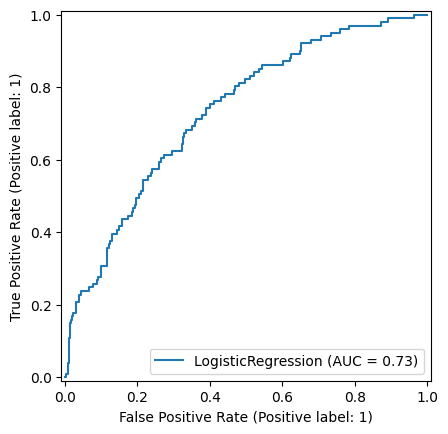

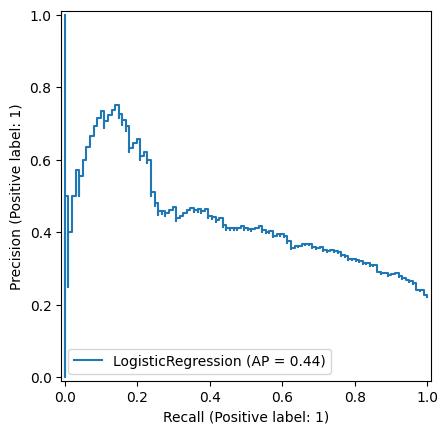

In [54]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [55]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [56]:
roc_df.to_csv(
    "roc/ecoli.tsv",
    sep="\t"
)

# Probability Prediction

In [57]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [58]:
predict_data = predict_data[protein_columns].copy()

In [59]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [60]:
predict_data['ecoli_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [61]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['ecoli_probability']
).reset_index()

In [62]:
predict_data[['ecoli_probability']].to_csv(
    "predictions_test/ecoli.tsv",
    sep="\t"
)

<Axes: xlabel='ecoli_probability', ylabel='Count'>

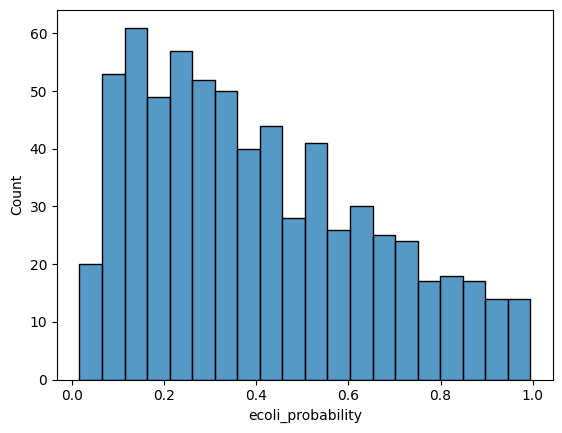

In [63]:
sns.histplot(
    data=design_matrix_test,
    x="ecoli_probability",
    #hue="sofa_ecoli_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [64]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [65]:
val_data = val_data[protein_columns].copy()

In [66]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [67]:
val_data['ecoli_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [68]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['ecoli_probability']
).reset_index()

In [69]:
val_data[['ecoli_probability']].to_csv(
    "predictions_val/ecoli.tsv",
    sep="\t"
)

<Axes: xlabel='ecoli_probability', ylabel='Count'>

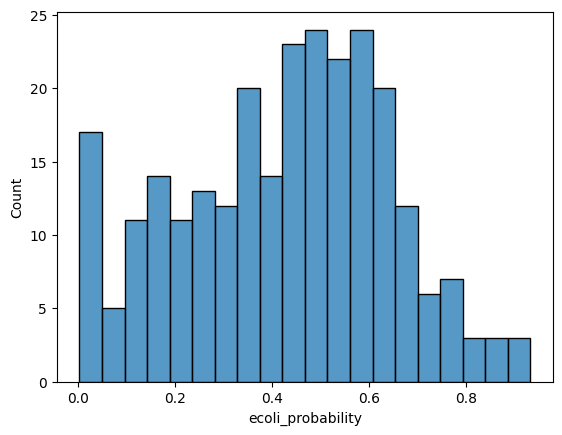

In [70]:
sns.histplot(
    data=design_matrix_val,
    x="ecoli_probability",
    #hue="sofa_ecoli_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [71]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [72]:
hero_data = hero_data[protein_columns].copy()

In [73]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [74]:
hero_data['ecoli_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [75]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['ecoli_probability']
).reset_index()

In [76]:
hero_data[['ecoli_probability']].to_csv(
    "predictions_external/ecoli.tsv",
    sep="\t"
)

<Axes: xlabel='ecoli_probability', ylabel='Count'>

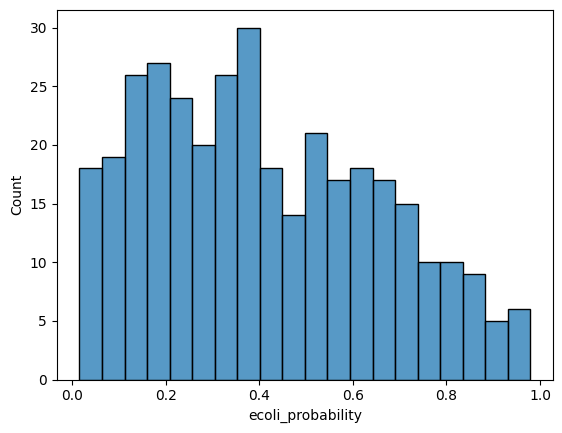

In [77]:
sns.histplot(
    data=hero_data,
    x="ecoli_probability",
    #hue="sofa_ecoli_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [78]:
from joblib import dump


with open("models/ecoli_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/ecoli_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
